https://www.kaggle.com/yassineghouzam/titanic-top-4-with-ensemble-modeling

In [275]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display

from collections import Counter

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve

%matplotlib inline

## 1 Read Data

### 1.1 训练集

In [201]:
train_df = pd.read_csv('input/train.csv')
display(train_df.head())

train_df.info()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


这里的特征含义我都比较熟悉了，就不详细介绍了。这里最重要是可以看到哪些属性有NaN值，然后我们要对NaN值进行处理。

- Age 有170+个NaN值，该属性还比较重要，所以要对NaN值进行填充
- Cabin 有600+个NaN值，缺失的太多，准备舍弃掉该特征
- Embarked 有2个NaN值


### 1.2 测试集：

In [202]:
test_df = pd.read_csv('input/test.csv')
display(test_df.head())

test_df.info()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


NaN值：

- Age 有80+个，需要进行填充
- Fare 有1个，需要填充
- Cabin 有300+个NaN值，准备舍弃

### 1.3 去除干扰点

In [206]:
def detect_outliers(df,n,features):
    """
    Takes a dataframe df of features and returns a list of the indices
    corresponding to the observations containing more than n outliers according
    to the Tukey method.
    """
    outlier_indices = []
    
    # iterate over features(columns)
    for col in features:
        # 1st quartile (25%)
        Q1 = np.percentile(df[col], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[col],75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1
        
        # outlier step
        outlier_step = 1.5 * IQR
        
        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index
        
        # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)
        
    # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > n )
    
    return multiple_outliers

# detect outliers from Age, SibSp , Parch and Fare
Outliers_to_drop = detect_outliers(train_df,2,["Age","SibSp","Parch","Fare"])

C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:4116: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


In [208]:
train_df.loc[Outliers_to_drop]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.00,C23 C25 C27,S
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.00,C23 C25 C27,S
159,160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S
180,181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S
201,202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S
324,325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S
341,342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.00,C23 C25 C27,S
792,793,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S
846,847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,NaN,S


干扰点28、89、342是由于价格太高，其余的则是SibSp太多。

In [209]:
# Drop outliers
train_df = train_df.drop(Outliers_to_drop, axis = 0).reset_index(drop=True)

### 1.4 合并数据

In [405]:
full_df = pd.concat([train_df, test_df], ignore_index=True)

full_df

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450
5,NaN,NaN,Q,8.4583,"Moran, Mr. James",0,6,3,male,0,0.0,330877
6,54.0,E46,S,51.8625,"McCarthy, Mr. Timothy J",0,7,1,male,0,0.0,17463
7,2.0,NaN,S,21.0750,"Palsson, Master. Gosta Leonard",1,8,3,male,3,0.0,349909
8,27.0,NaN,S,11.1333,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",2,9,3,female,0,1.0,347742
9,14.0,NaN,C,30.0708,"Nasser, Mrs. Nicholas (Adele Achem)",0,10,2,female,1,1.0,237736


## 2 缺失值处理

### 2.1 Embarked

Embarked只有两个缺失值，可以采用出现次数最多的港口（S）进行填充。

在这里，我认为相同的船舱等级、相同的港口登船的票价应该也是接近的，用这种方式进行填充。

我先对Pclass（=1）的乘客按各港口求票价中值，取票价中值与乘客票价最接近的港口（C）来进行填充。

In [364]:
full_df.loc[full_df['Embarked'].isnull(), :]

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
60,38.0,B28,NaN,80.0,"Icard, Miss. Amelie",0,62,1,female,0,1.0,113572
821,62.0,B28,NaN,80.0,"Stone, Mrs. George Nelson (Martha Evelyn)",0,830,1,female,0,1.0,113572


In [365]:
full_df[(full_df['Pclass']==1)].groupby('Embarked')['Fare'].median()

Embarked
C    76.7292
Q    90.0000
S    52.0000
Name: Fare, dtype: float64

In [406]:
full_df.loc[full_df['Embarked'].isnull(), 'Embarked'] = 'S'

### 2.2 Fare

我们用与缺失值相同Pclass、相同Embarked的票价中值来填充。

In [407]:
full_df.loc[full_df['Fare'].isnull(), :]

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
1033,60.5,NaN,S,NaN,"Storey, Mr. Thomas",0,1044,3,male,0,NaN,3701


In [408]:
full_df.loc[full_df['Fare'].isnull(), 'Fare'] = \
full_df[(full_df['Pclass']==3) & (full_df['Embarked']=='S')]['Fare'].median()

### 2.3 Age

先看看Pclass、Parch、SibSp、Sex与Age的关系。

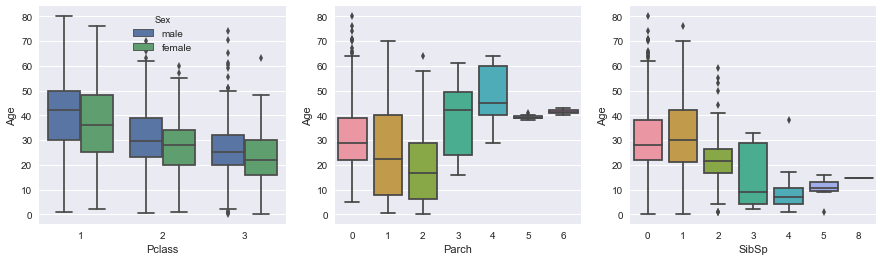

In [409]:
df_age = full_df.loc[~full_df['Age'].isnull(), :]

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 4))

g = sns.boxplot(x='Pclass', y='Age', hue='Sex', data=df_age, ax=axs[0])
g = sns.boxplot('Parch', 'Age', data=df_age, ax=axs[1])
g = sns.boxplot('SibSp', 'Age', data=df_age, ax=axs[2])

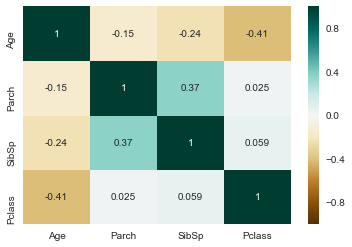

In [410]:
g = sns.heatmap(df_age[['Age', 'Sex', 'Parch', 'SibSp', 'Pclass']].corr(), cmap='BrBG', annot=True)

Age与Pclass、SibSp、Pclass的相关性都挺强的。Sex与Age的关系不是很强，但是Pclass结合Sex应该比直接使用Pclass更精确，所以Sex也用上。

In [411]:
for id in full_df['PassengerId']:
    passenger = full_df[full_df['PassengerId']==id].iloc[0]

    if np.isnan(passenger['Age']):
        age_pred = full_df['Age'][(full_df['Pclass'] == passenger['Pclass']) 
                                    & (full_df['Sex'] == passenger['Sex'])
                                    & (full_df['SibSp'] == passenger['SibSp'])
                                    & (full_df['Parch'] == passenger['Parch'])
                                      ].median()

        if np.isnan(age_pred):
            age_pred = full_df['Age'][(full_df['Pclass'] == passenger['Pclass']) 
                                        & (full_df['SibSp'] == passenger['SibSp'])
                                        & (full_df['Parch'] == passenger['Parch'])
                                          ].median()
            
        if np.isnan(age_pred):
            age_pred = full_df['Age'][(full_df['Pclass'] == passenger['Pclass']) 
                                        & (full_df['Parch'] == passenger['Parch'])
                                         ].median()
        
        if np.isnan(age_pred):
            age_pred = full_df['Age'][full_df['Pclass'] == passenger['Pclass']].median()

        full_df.loc[full_df['PassengerId']==id, 'Age'] = age_pred

In [372]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1299 entries, 0 to 1298
Data columns (total 12 columns):
Age            1299 non-null float64
Cabin          292 non-null object
Embarked       1299 non-null object
Fare           1299 non-null float64
Name           1299 non-null object
Parch          1299 non-null int64
PassengerId    1299 non-null int64
Pclass         1299 non-null int64
Sex            1299 non-null object
SibSp          1299 non-null int64
Survived       881 non-null float64
Ticket         1299 non-null object
dtypes: float64(3), int64(4), object(5)
memory usage: 121.9+ KB


## 3 特征处理


### 3.1 Name

Name中提取Title

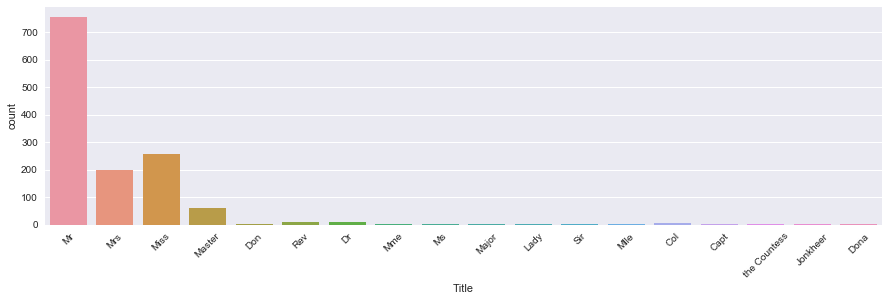

In [412]:
full_df['Title'] = pd.Series([name.split(',')[1].split('.')[0].strip() for name in full_df['Name']])

plt.figure(figsize=(15, 4))
g = sns.countplot(full_df['Title'])
g = plt.setp(g.get_xticklabels(), rotation=45)

In [413]:
full_df['Title'] = full_df['Title'].replace(
    ['Lady', 'the Countess','Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 
    'Rare'
)
full_df['Title'] = full_df['Title'].map(
    {"Master":0, "Miss":1, "Ms" : 1 , "Mme":1, "Mlle":1, "Mrs":1, "Mr":2, "Rare":3}
)
full_df['Title'] = full_df['Title'].astype(int)

full_df['Title'].value_counts()

2    753
1    457
0     60
3     29
Name: Title, dtype: int64

In [414]:
full_df.drop('Name', axis=1, inplace=True)

full_df.head()

,Age,Cabin,Embarked,Fare,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Title
0,22.0,NaN,S,7.2500,0,1,3,male,1,0.0,A/5 21171,2
1,38.0,C85,C,71.2833,0,2,1,female,1,1.0,PC 17599,1
2,26.0,NaN,S,7.9250,0,3,3,female,0,1.0,STON/O2. 3101282,1
3,35.0,C123,S,53.1000,0,4,1,female,1,1.0,113803,1
4,35.0,NaN,S,8.0500,0,5,3,male,0,0.0,373450,2


In [415]:
full_df = pd.get_dummies(full_df, columns = ["Title"])

full_df.head()

,Age,Cabin,Embarked,Fare,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Title_0,Title_1,Title_2,Title_3
0,22.0,NaN,S,7.2500,0,1,3,male,1,0.0,A/5 21171,0,0,1,0
1,38.0,C85,C,71.2833,0,2,1,female,1,1.0,PC 17599,0,1,0,0
2,26.0,NaN,S,7.9250,0,3,3,female,0,1.0,STON/O2. 3101282,0,1,0,0
3,35.0,C123,S,53.1000,0,4,1,female,1,1.0,113803,0,1,0,0
4,35.0,NaN,S,8.0500,0,5,3,male,0,0.0,373450,0,0,1,0


### 3.2 Sex

In [416]:
full_df['Sex'] = full_df['Sex'].map({'male': 0, 'female': 1})

full_df.head()

,Age,Cabin,Embarked,Fare,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Title_0,Title_1,Title_2,Title_3
0,22.0,NaN,S,7.2500,0,1,3,0,1,0.0,A/5 21171,0,0,1,0
1,38.0,C85,C,71.2833,0,2,1,1,1,1.0,PC 17599,0,1,0,0
2,26.0,NaN,S,7.9250,0,3,3,1,0,1.0,STON/O2. 3101282,0,1,0,0
3,35.0,C123,S,53.1000,0,4,1,1,1,1.0,113803,0,1,0,0
4,35.0,NaN,S,8.0500,0,5,3,0,0,0.0,373450,0,0,1,0


### 3.3 Embarked

In [417]:
full_df = pd.get_dummies(full_df, columns = ['Embarked'])

full_df.head()

,Age,Cabin,Fare,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Title_0,Title_1,Title_2,Title_3,Embarked_C,Embarked_Q,Embarked_S
0,22.0,NaN,7.2500,0,1,3,0,1,0.0,A/5 21171,0,0,1,0,0,0,1
1,38.0,C85,71.2833,0,2,1,1,1,1.0,PC 17599,0,1,0,0,1,0,0
2,26.0,NaN,7.9250,0,3,3,1,0,1.0,STON/O2. 3101282,0,1,0,0,0,0,1
3,35.0,C123,53.1000,0,4,1,1,1,1.0,113803,0,1,0,0,0,0,1
4,35.0,NaN,8.0500,0,5,3,0,0,0.0,373450,0,0,1,0,0,0,1


### 3.4 Family size

In [418]:
full_df['Fsize'] = full_df['Parch'] + full_df['SibSp'] + 1

# Create new feature of family size
full_df['Single'] = full_df['Fsize'].map(lambda s: 1 if s == 1 else 0)
full_df['SmallF'] = full_df['Fsize'].map(lambda s: 1 if  s == 2  else 0)
full_df['MedF'] = full_df['Fsize'].map(lambda s: 1 if 3 <= s <= 4 else 0)
full_df['LargeF'] = full_df['Fsize'].map(lambda s: 1 if s >= 5 else 0)

full_df.head()

,Age,Cabin,Fare,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,...,Title_2,Title_3,Embarked_C,Embarked_Q,Embarked_S,Fsize,Single,SmallF,MedF,LargeF
0,22.0,NaN,7.2500,0,1,3,0,1,0.0,A/5 21171,...,1,0,0,0,1,2,0,1,0,0
1,38.0,C85,71.2833,0,2,1,1,1,1.0,PC 17599,...,0,0,1,0,0,2,0,1,0,0
2,26.0,NaN,7.9250,0,3,3,1,0,1.0,STON/O2. 3101282,...,0,0,0,0,1,1,1,0,0,0
3,35.0,C123,53.1000,0,4,1,1,1,1.0,113803,...,0,0,0,0,1,2,0,1,0,0
4,35.0,NaN,8.0500,0,5,3,0,0,0.0,373450,...,1,0,0,0,1,1,1,0,0,0


### 3.5 Cabin

In [419]:
# Replace the Cabin number by the type of cabin 'X' if not
full_df["Cabin"] = pd.Series([i[0] if not pd.isnull(i) else 'X' for i in full_df['Cabin'] ])

full_df = pd.get_dummies(full_df, columns = ["Cabin"], prefix="Cabin")

full_df.head()

,Age,Fare,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Title_0,...,LargeF,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Cabin_X
0,22.0,7.2500,0,1,3,0,1,0.0,A/5 21171,0,...,0,0,0,0,0,0,0,0,0,1
1,38.0,71.2833,0,2,1,1,1,1.0,PC 17599,0,...,0,0,0,1,0,0,0,0,0,0
2,26.0,7.9250,0,3,3,1,0,1.0,STON/O2. 3101282,0,...,0,0,0,0,0,0,0,0,0,1
3,35.0,53.1000,0,4,1,1,1,1.0,113803,0,...,0,0,0,1,0,0,0,0,0,0
4,35.0,8.0500,0,5,3,0,0,0.0,373450,0,...,0,0,0,0,0,0,0,0,0,1


### 3.6 Ticket

In [420]:
## Treat Ticket by extracting the ticket prefix. When there is no prefix it returns X. 

Ticket = []
for i in list(full_df.Ticket):
    if not i.isdigit() :
        Ticket.append(i.replace(".","").replace("/","").strip().split(' ')[0]) #Take prefix
    else:
        Ticket.append("X")

full_df["Ticket"] = Ticket
full_df = pd.get_dummies(full_df, columns = ["Ticket"], prefix="T")

full_df.head()

,Age,Fare,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Title_0,Title_1,...,T_SOTONO2,T_SOTONOQ,T_SP,T_STONO,T_STONO2,T_STONOQ,T_SWPP,T_WC,T_WEP,T_X
0,22.0,7.2500,0,1,3,0,1,0.0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,38.0,71.2833,0,2,1,1,1,1.0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,26.0,7.9250,0,3,3,1,0,1.0,0,1,...,0,0,0,0,1,0,0,0,0,0
3,35.0,53.1000,0,4,1,1,1,1.0,0,1,...,0,0,0,0,0,0,0,0,0,1
4,35.0,8.0500,0,5,3,0,0,0.0,0,0,...,0,0,0,0,0,0,0,0,0,1


### 3.7 Pclass

In [421]:
full_df["Pclass"] = full_df["Pclass"].astype("category")
full_df = pd.get_dummies(full_df, columns=['Pclass'], prefix="Pc")

full_df.head()

,Age,Fare,Parch,PassengerId,Sex,SibSp,Survived,Title_0,Title_1,Title_2,...,T_STONO,T_STONO2,T_STONOQ,T_SWPP,T_WC,T_WEP,T_X,Pc_1,Pc_2,Pc_3
0,22.0,7.2500,0,1,0,1,0.0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
1,38.0,71.2833,0,2,1,1,1.0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
2,26.0,7.9250,0,3,1,0,1.0,0,1,0,...,0,1,0,0,0,0,0,0,0,1
3,35.0,53.1000,0,4,1,1,1.0,0,1,0,...,0,0,0,0,0,0,1,1,0,0
4,35.0,8.0500,0,5,0,0,0.0,0,0,1,...,0,0,0,0,0,0,1,0,0,1


### 3.8 Drop

In [423]:
full_df.drop([ 'PassengerId'], axis=1, inplace=True)

full_df.head()

,Age,Fare,Parch,Sex,SibSp,Survived,Title_0,Title_1,Title_2,Title_3,...,T_STONO,T_STONO2,T_STONOQ,T_SWPP,T_WC,T_WEP,T_X,Pc_1,Pc_2,Pc_3
0,22.0,7.2500,0,0,1,0.0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
1,38.0,71.2833,0,1,1,1.0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,26.0,7.9250,0,1,0,1.0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,1
3,35.0,53.1000,0,1,1,1.0,0,1,0,0,...,0,0,0,0,0,0,1,1,0,0
4,35.0,8.0500,0,0,0,0.0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,1


In [424]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1299 entries, 0 to 1298
Data columns (total 67 columns):
Age           1299 non-null float64
Fare          1299 non-null float64
Parch         1299 non-null int64
Sex           1299 non-null int64
SibSp         1299 non-null int64
Survived      881 non-null float64
Title_0       1299 non-null uint8
Title_1       1299 non-null uint8
Title_2       1299 non-null uint8
Title_3       1299 non-null uint8
Embarked_C    1299 non-null uint8
Embarked_Q    1299 non-null uint8
Embarked_S    1299 non-null uint8
Fsize         1299 non-null int64
Single        1299 non-null int64
SmallF        1299 non-null int64
MedF          1299 non-null int64
LargeF        1299 non-null int64
Cabin_A       1299 non-null uint8
Cabin_B       1299 non-null uint8
Cabin_C       1299 non-null uint8
Cabin_D       1299 non-null uint8
Cabin_E       1299 non-null uint8
Cabin_F       1299 non-null uint8
Cabin_G       1299 non-null uint8
Cabin_T       1299 non-null uint8
Cabi

## 4 数据集

In [425]:
train = full_df[:len(train_df)]
train['Survived'] = train['Survived'].astype(int)

test = full_df[len(train_df):]
test.drop("Survived", axis = 1, inplace=True)

X = train.drop('Survived', axis=1)
y = train['Survived']

X_test = test

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [387]:
train

,Age,Fare,Parch,Sex,SibSp,Survived,Title_0,Title_1,Title_2,Title_3,...,T_STONO,T_STONO2,T_STONOQ,T_SWPP,T_WC,T_WEP,T_X,Pc_1,Pc_2,Pc_3
0,22.000,7.2500,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
1,38.000,71.2833,0,1,1,1,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,26.000,7.9250,0,1,0,1,0,1,0,0,...,0,1,0,0,0,0,0,0,0,1
3,35.000,53.1000,0,1,1,1,0,1,0,0,...,0,0,0,0,0,0,1,1,0,0
4,35.000,8.0500,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,1
5,26.000,8.4583,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,1
6,54.000,51.8625,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,1,0,0
7,2.000,21.0750,1,0,3,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,1
8,27.000,11.1333,2,1,0,1,0,1,0,0,...,0,0,0,0,0,0,1,0,0,1
9,14.000,30.0708,0,1,1,1,0,1,0,0,...,0,0,0,0,0,0,1,0,1,0


In [388]:
test

,Age,Fare,Parch,Sex,SibSp,Title_0,Title_1,Title_2,Title_3,Embarked_C,...,T_STONO,T_STONO2,T_STONOQ,T_SWPP,T_WC,T_WEP,T_X,Pc_1,Pc_2,Pc_3
881,34.5,7.8292,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,1
882,47.0,7.0000,0,1,1,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,1
883,62.0,9.6875,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,1,0
884,27.0,8.6625,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,1
885,22.0,12.2875,1,1,1,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,1
886,14.0,9.2250,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,1
887,30.0,7.6292,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,1
888,26.0,29.0000,1,0,1,0,0,1,0,0,...,0,0,0,0,0,0,1,0,1,0
889,18.0,7.2292,0,1,0,0,1,0,0,1,...,0,0,0,0,0,0,1,0,0,1
890,21.0,24.1500,0,0,2,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1


## 5 学习

### 5.1 基础学习

In [426]:
kfold = StratifiedKFold(n_splits=10)

# Modeling step Test differents algorithms 
random_state = 2
classifiers = []
classifiers.append(SVC(random_state=random_state))
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),random_state=random_state,learning_rate=0.1))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(MLPClassifier(random_state=random_state))
classifiers.append(KNeighborsClassifier())
classifiers.append(LogisticRegression(random_state = random_state))
classifiers.append(LinearDiscriminantAnalysis())

cv_results = []
for classifier in classifiers:
    cv_results.append(cross_val_score(classifier, X=X, y=y, scoring="accuracy", cv=kfold, n_jobs=4))

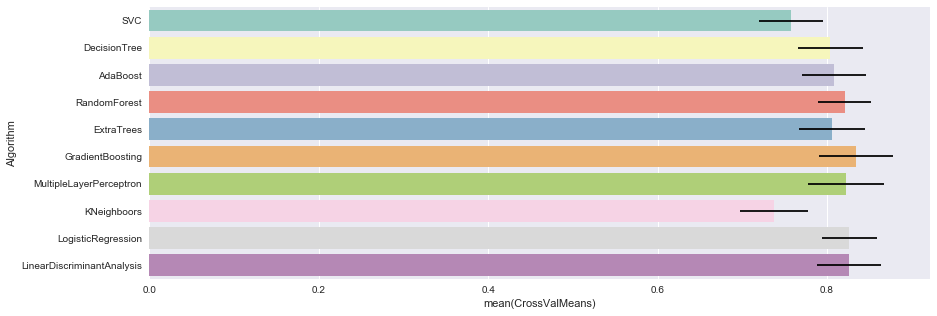

In [427]:
cv_means = []
cv_stds = []
for result in cv_results:
    cv_means.append(result.mean())
    cv_stds.append(result.std())
    
cv_res = pd.DataFrame(
    {"CrossValMeans":cv_means,
     "CrossValerrors": cv_stds,
     "Algorithm":["SVC","DecisionTree","AdaBoost","RandomForest","ExtraTrees",
                  "GradientBoosting","MultipleLayerPerceptron","KNeighboors",
                  "LogisticRegression","LinearDiscriminantAnalysis"
                 ]
    }
)

plt.figure(figsize=(14, 5))
g = sns.barplot(x='CrossValMeans', y='Algorithm', data=cv_res, palette="Set3", orient="h", **{'xerr':cv_stds})

### 5.2 参数选择

#### 5.2.1 AdaBoost

In [428]:
DTC = DecisionTreeClassifier()

adaDTC = AdaBoostClassifier(DTC, random_state=7)

ada_param_grid = {
    "base_estimator__criterion" : ["gini", "entropy"],
    "base_estimator__splitter" :   ["best", "random"],
    "algorithm" : ["SAMME","SAMME.R"],
    "n_estimators" :[1,2],
    "learning_rate":  [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3,1.5]
}

gsadaDTC = GridSearchCV(adaDTC, param_grid=ada_param_grid, scoring="accuracy", cv=kfold, n_jobs=4, verbose=1)
gsadaDTC.fit(X, y)

ada_best = gsadaDTC.best_estimator_

print(gsadaDTC.best_score_)

Fitting 10 folds for each of 112 candidates, totalling 1120 fits


[Parallel(n_jobs=4)]: Done  89 tasks      | elapsed:    4.9s


0.816118047673


[Parallel(n_jobs=4)]: Done 1120 out of 1120 | elapsed:    8.1s finished


#### 5.2.2 ExtraTrees 

In [429]:
ExtC = ExtraTreesClassifier()

## Search grid for optimal parameters
ex_param_grid = {
    "max_depth": [None],
    "max_features": [1, 3, 10],
    "min_samples_split": [2, 3, 10],
    "min_samples_leaf": [1, 3, 10],
    "bootstrap": [False],
    "n_estimators" :[100,300],
    "criterion": ["gini"]
}

gsExtC = GridSearchCV(ExtC, param_grid=ex_param_grid, scoring="accuracy", cv=kfold, n_jobs=4, verbose=1)
gsExtC.fit(X, y)

ExtC_best = gsExtC.best_estimator_

gsExtC.best_score_

Fitting 10 folds for each of 54 candidates, totalling 540 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    9.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   22.7s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   49.2s
[Parallel(n_jobs=4)]: Done 540 out of 540 | elapsed:   59.4s finished


0.83087400681044266

#### 5.2.3 RandomForestClassifier

In [430]:
RFC = RandomForestClassifier()

## Search grid for optimal parameters
rf_param_grid = {
    "max_depth": [None],
    "max_features": [1, 3, 10],
    "min_samples_split": [2, 3, 10],
    "min_samples_leaf": [1, 3, 10],
    "bootstrap": [False],
    "n_estimators" :[100,300],
    "criterion": ["gini"]
}


gsRFC = GridSearchCV(RFC,param_grid = rf_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsRFC.fit(X, y)

RFC_best = gsRFC.best_estimator_

# Best score
gsRFC.best_score_

Fitting 10 folds for each of 54 candidates, totalling 540 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   10.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   25.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   53.4s
[Parallel(n_jobs=4)]: Done 540 out of 540 | elapsed:  1.1min finished


0.83654937570942112

#### 5.2.4 Gradient boosting

In [431]:
# Gradient boosting tunning

GBC = GradientBoostingClassifier()
gb_param_grid = {
    'loss' : ["deviance"],
    'n_estimators' : [100,200,300],
    'learning_rate': [0.1, 0.05, 0.01],
    'max_depth': [4, 8],
    'min_samples_leaf': [100,150],
    'max_features': [0.3, 0.1] 
}

gsGBC = GridSearchCV(GBC, param_grid = gb_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsGBC.fit(X, y)

GBC_best = gsGBC.best_estimator_

# Best score
gsGBC.best_score_

Fitting 10 folds for each of 72 candidates, totalling 720 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    6.2s
[Parallel(n_jobs=4)]: Done 307 tasks      | elapsed:   15.9s
[Parallel(n_jobs=4)]: Done 713 out of 720 | elapsed:   31.0s remaining:    0.2s
[Parallel(n_jobs=4)]: Done 720 out of 720 | elapsed:   31.2s finished


0.8354143019296254

#### 5.2.5 LogisticRegression

In [432]:
LR = LogisticRegression()
lr_param_grid = {
    'C' : [0.1, 1, 10, 30]
}

gsLR = GridSearchCV(LR, param_grid = lr_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsLR.fit(X, y)

LR_best = gsLR.best_estimator_

# Best score
gsLR.best_score_

Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=4)]: Done  33 out of  40 | elapsed:    5.0s remaining:    1.0s
[Parallel(n_jobs=4)]: Done  40 out of  40 | elapsed:    5.1s finished


0.82746878547105562

#### 5.2.6 SVC

In [433]:
### SVC classifier
SVMC = SVC(probability=True)
svc_param_grid = {'kernel': ['rbf'], 
                  'gamma': [ 0.001, 0.01, 0.1, 1],
                  'C': [1, 10, 50, 100,200,300, 1000]}

gsSVMC = GridSearchCV(SVMC,param_grid = svc_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsSVMC.fit(X, y)

SVMC_best = gsSVMC.best_estimator_

# Best score
gsSVMC.best_score_

Fitting 10 folds for each of 28 candidates, totalling 280 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    8.7s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   26.7s
[Parallel(n_jobs=4)]: Done 280 out of 280 | elapsed:   40.6s finished


0.81725312145289442

### 5.3 绘制学习过程

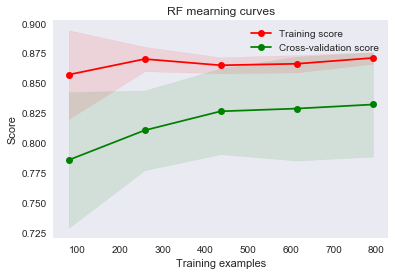

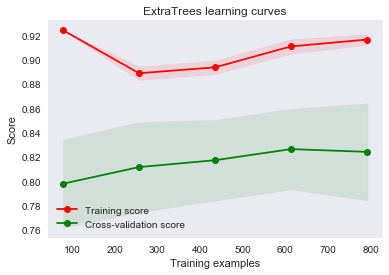

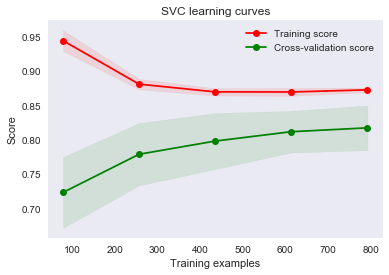

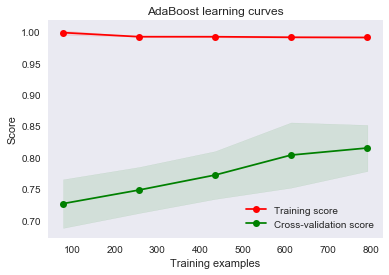

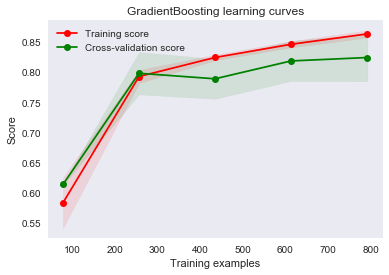

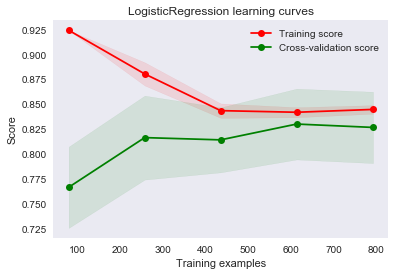

In [434]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    """Generate a simple plot of the test and training learning curve"""
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

g = plot_learning_curve(gsRFC.best_estimator_,"RF mearning curves",X,y,cv=kfold)
g = plot_learning_curve(gsExtC.best_estimator_,"ExtraTrees learning curves",X,y,cv=kfold)
g = plot_learning_curve(gsSVMC.best_estimator_,"SVC learning curves",X,y,cv=kfold)
g = plot_learning_curve(gsadaDTC.best_estimator_,"AdaBoost learning curves",X,y,cv=kfold)
g = plot_learning_curve(gsGBC.best_estimator_,"GradientBoosting learning curves",X,y,cv=kfold)
g = plot_learning_curve(gsLR.best_estimator_,"LogisticRegression learning curves",X,y,cv=kfold)

### 5.4 特征重要程度

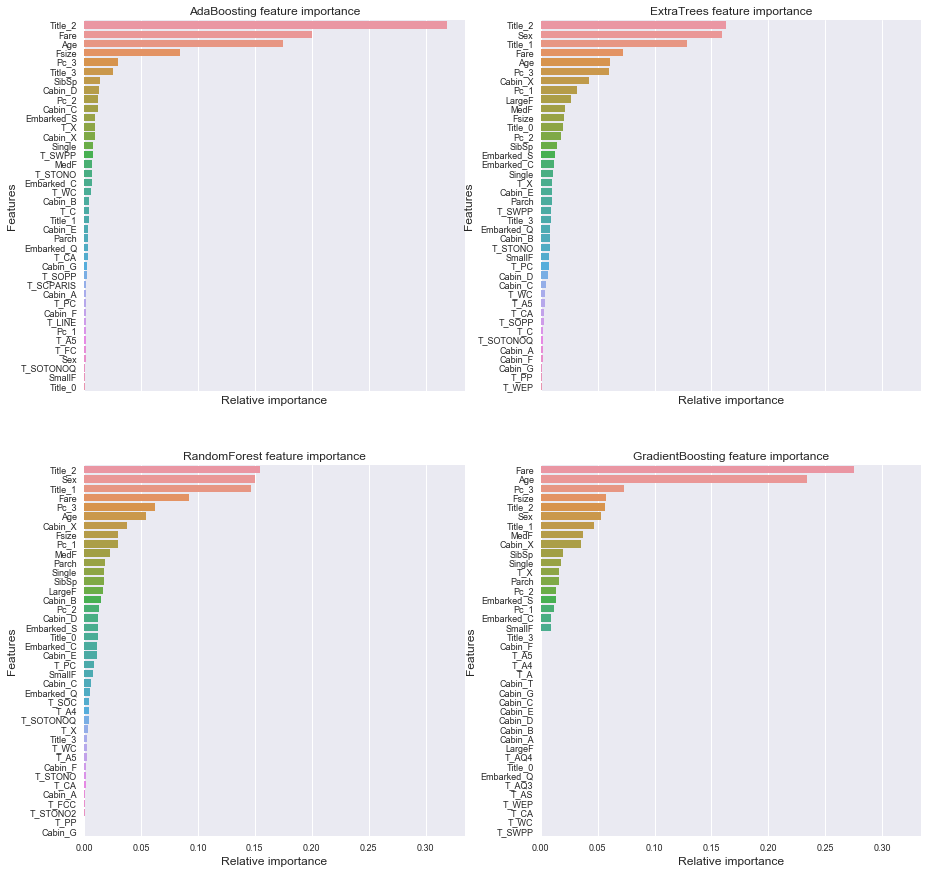

In [435]:
nrows = ncols = 2
fig, axes = plt.subplots(nrows = nrows, ncols = ncols, sharex="all", figsize=(15,15))

names_classifiers = [("AdaBoosting", ada_best),("ExtraTrees",ExtC_best),("RandomForest",RFC_best),("GradientBoosting",GBC_best)]

nclassifier = 0
for row in range(nrows):
    for col in range(ncols):
        name = names_classifiers[nclassifier][0]
        classifier = names_classifiers[nclassifier][1]
        indices = np.argsort(classifier.feature_importances_)[::-1][:40]
        g = sns.barplot(y=X.columns[indices][:40],x = classifier.feature_importances_[indices][:40] , orient='h',ax=axes[row][col])
        g.set_xlabel("Relative importance",fontsize=12)
        g.set_ylabel("Features",fontsize=12)
        g.tick_params(labelsize=9)
        g.set_title(name + " feature importance")
        nclassifier += 1

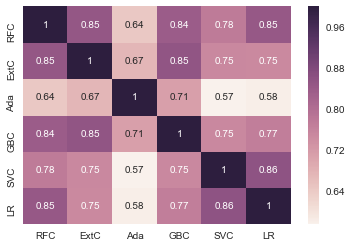

In [436]:
test_Survived_RFC = pd.Series(RFC_best.predict(test), name="RFC")
test_Survived_ExtC = pd.Series(ExtC_best.predict(test), name="ExtC")
test_Survived_SVMC = pd.Series(SVMC_best.predict(test), name="SVC")
test_Survived_AdaC = pd.Series(ada_best.predict(test), name="Ada")
test_Survived_GBC = pd.Series(GBC_best.predict(test), name="GBC")
test_Survived_LR = pd.Series(LR_best.predict(test), name="LR")


# Concatenate all classifier results
ensemble_results = pd.concat([test_Survived_RFC,test_Survived_ExtC,test_Survived_AdaC,test_Survived_GBC, test_Survived_SVMC, test_Survived_LR],axis=1)


g= sns.heatmap(ensemble_results.corr(),annot=True)

### 5.5 组合学习器

In [437]:
votingC = VotingClassifier(
    estimators=[('rfc', RFC_best), ('extc', ExtC_best), ('svc', SVMC_best), ('lr', LR_best), ('gbc',GBC_best)], 
    voting='soft', n_jobs=4
)

votingC = votingC.fit(X, y)

### 5.6 预测结果

In [438]:
test_Survived = pd.Series(votingC.predict(test), name="Survived")

results = pd.concat([test_df["PassengerId"],test_Survived],axis=1)

results.to_csv("output/ensemble_python_voting.csv",index=False)